In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import mean_absolute_error as MAE

In [2]:
vanila_data = pd.read_csv('../data/train.csv')
# vanila_data = pd.read_csv('dataset_ver2.csv')
location = pd.read_csv('../data/location.csv', delimiter=';')
product = pd.read_csv('../data/product.csv', delimiter=';')
vanila_test = pd.read_csv('../data/test.csv')

In [3]:
# def read_ts_dataset(path):
#     res = pd.read_csv(path)
#     res.index = res.week_num.astype(int)
#     res = res.reindex(np.arange(1, 160))
#     res = res.drop(columns=['week_num'])
#     return res

# loc_prod_ts = read_ts_dataset('timeseries/loc_prod.csv')
# loc_prodRK_ts = read_ts_dataset('timeseries/loc_prodRK6.csv')
# locRK_prod_ts = read_ts_dataset('timeseries/locRK3_prod.csv')
# locRK_prodRK_ts = read_ts_dataset('timeseries/locRK3_prodRK6.csv')

In [4]:
# создаем "тупые" фичи

data = vanila_data[(~vanila_data.location_id.isna()) & (~vanila_data.product_id.isna())].copy()

data['sale'] = (data['PRICE_REGULAR'] - data['PRICE_AFTER_DISC'])
data['sale_part'] = (data['PRICE_REGULAR'] - data['PRICE_AFTER_DISC']) / data['PRICE_REGULAR']
data['period_dt'] = pd.to_datetime(data["period_dt"])
data['week_in_year'] = data["period_dt"].dt.isocalendar().week.astype(int)
data['year_num'] = data["period_dt"].dt.isocalendar().year.astype(int) - 2016
data['week_num'] = data['week_in_year'] + data['year_num']*52 - 50

data.sort_values(by=['week_num'], inplace=True)

In [5]:
# is_first -- индикатор [первый раз встретилась пара product_id - location_id]

data['num_hist'] = -1

pos = pd.MultiIndex.from_frame(data.groupby(by=['location_id', 'product_id']).week_num.nth(0).reset_index())
data.index = pd.MultiIndex.from_frame(data[['location_id', 'product_id', 'week_num']])
data.loc[pos, 'num_hist'] = 1
data.index = data.id

pos = pd.MultiIndex.from_frame(data.groupby(by=['location_id', 'product_id']).week_num.nth(1).reset_index())
data.index = pd.MultiIndex.from_frame(data[['location_id', 'product_id', 'week_num']])
data.loc[pos, 'num_hist'] = 2
data.index = data.id

# pos = pd.MultiIndex.from_frame(data.groupby(by=['location_id', 'product_id']).week_num.nth(3).reset_index())
# data.index = pd.MultiIndex.from_frame(data[['location_id', 'product_id', 'week_num']])
# data.loc[pos, 'num_hist'] = 3
# data.index = data.id

# pos = pd.MultiIndex.from_frame(data.groupby(by=['location_id', 'product_id']).week_num.nth(4).reset_index())
# data.index = pd.MultiIndex.from_frame(data[['location_id', 'product_id', 'week_num']])
# data.loc[pos, 'num_hist'] = 4
# data.index = data.id

In [6]:
data = data[data.num_hist != -1]

In [7]:
# фиксируем индексы валидационной выборки

validation_weeks = [104, 105, 106, 107]
validation_ids = data[data.week_num.isin(validation_weeks) & (data.num_hist == 1)].id

# выкидываем на всякий случай прошлогоднюю неделю

# data = data[~data.week_num.isin(validation_weeks)]

In [8]:
# tmp = loc_prod_ts.ewm(halflife=3, ignore_na=True).mean()

In [9]:
# %%time
# a = 0
# for week_num in tqdm(tmp.index):
#     for column in tmp.columns[~tmp.isna().all()]:
#         a += 1
# print(a)

In [10]:
# tmp.stack().index#.apply(lambda row: (row[0], int(float(row[1].split('_')[0][5:]))))

In [11]:
# locRK_prodRK_ts.loc[155, :].isna().sum()

In [12]:
# locRK_prodRK_ts.shape

In [13]:
# pd.Series([1, 1, 0, 0]).ewm(halflife=4).mean()

In [14]:
data.index = data.location_id
location.index = location.STORE_LOCATION_RK
data = data.join(location.drop(columns=['STORE_LOCATION_RK']), rsuffix='_location')



In [15]:
# добавляем параметры локации и продукта

data.index = data.location_id
location.index = location.STORE_LOCATION_RK
data = data.join(location.drop(columns=['STORE_LOCATION_RK']), rsuffix='_location')

# data.index = data.product_id
# product.index = product.PRODUCT_RK
# data = data.join(product.drop(columns=['PRODUCT_RK']), rsuffix='_product')

data.index = data.id

In [16]:
mean_at_loc_RK = data.groupby(by='STORE_LOCATION_LVL_RK3').demand.mean()
# mean_at_prod_RK = data.groupby(by='PRODUCT_LVL_RK6').demand.mean()

data.index = data.STORE_LOCATION_LVL_RK3
data['mean_at_loc_RK'] = mean_at_loc_RK

# data.index = data.PRODUCT_LVL_RK6
# data['mean_at_prod_RK'] = mean_at_prod_RK


In [17]:
data.week_in_year

STORE_LOCATION_LVL_RK3
203    51
203    51
203    51
203    51
203    51
       ..
219     1
219     1
219     1
219     1
219     1
Name: week_in_year, Length: 42075, dtype: int64

In [18]:
# Средние значения ответа
group_all = data[['week_in_year', 'location_id', 'demand']].groupby(by=['week_in_year', 'location_id'], as_index=False).mean()

group_date = data[['week_in_year', 'demand']].groupby(by=['week_in_year'], as_index=False).mean()

data = data.merge(group_all, on=['week_in_year', 'location_id'], how='left', suffixes=('', '_all'))
# test_data = test_data.merge(group_all, on=['week_in_year', 'location_id'], how='left', suffixes=('', '_all'))
data = data.merge(group_date, on=['week_in_year'], how='left', suffixes=('', '_new'))
# test_data = test_data.merge(group_date, on=['week_in_year'], how='left', suffixes=('', '_new'))



In [19]:
mean_at_loc_id = data.groupby(by='location_id').demand.mean()
mean_at_prod_id = data.groupby(by='product_id').demand.mean()

data.index = data.location_id
data['mean_at_loc_id'] = mean_at_loc_id

data.index = data.product_id
data['mean_at_prod_id'] = mean_at_prod_id


In [20]:
data.index = data.id

In [21]:
# определяем категориальные фичи

categorical_columns = [
    'location_id',
    'product_id',
    'PROMO1_FLAG',
    'PROMO2_FLAG',
    'AUTORIZATION_FLAG',
#     'special_week',
    'STORE_LOCATION_LVL_RK4',
    'STORE_LOCATION_LVL_RK3',
    'week_in_year',
#     'PRODUCT_LVL_RK6',
] + [
    column for column in data if column.find('hashing') != -1
]

In [22]:
# фильтруем строчки

# for column in tqdm(categorical_columns):
#     data = data[data[column].isin(data.loc[vanila_test.id, column].unique())]

# data = data[data.week_in_year.isin([1, 50, 51, 52])]

In [23]:
# фильтруем столбики

def get_large_nunique_columns(df, subset_columns=None, nunique_trhld = 100):
    res = []
    columns = subset_columns
    if subset_columns is None:
        columns = df.columns
    for column in tqdm(columns):
        if df[column].nunique() > nunique_trhld:
            res.append(column)
    return res

bad_features = [
    'period_dt',
    'id',
    'product_id',
    'VALID_FROM_DTTM',
    'VALID_TO_DTTM',
    'PROCESSED_DTTM',
#     'VALID_FROM_DTTM_product',
#     'VALID_TO_DTTM_product',
#     'PROCESSED_DTTM_product',
    'year_num',
    'week_num',
]

bad_features.extend(get_large_nunique_columns(
    data, 
    subset_columns=categorical_columns,
    nunique_trhld=100,
))

bad_features.extend([
    column for column in tqdm(data.drop(columns=['demand']).columns) if
    data.loc[data.id, column].nunique() < 2
])

data = data.drop(columns=bad_features)
categorical_columns = list(set(categorical_columns) - set(bad_features))
for column in tqdm(categorical_columns):
    data[column] = data[column].fillna('NaN').astype(str)

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

In [24]:
valid = data[data.index.isin(validation_ids)]
valid_target = valid['demand']
valid = valid.drop(columns=['demand'])
train = data[(~data.demand.isna()) & (~data.index.isin(valid.index))
            ].drop(columns=['demand'])
test = data.loc[vanila_test.id, :].drop(columns=['demand'])
target = data.loc[train.index, 'demand']

In [25]:
lims = [0.0, 0.99, 1.01, 1.5, 1.9, 2.1, 2.8, np.inf]

In [26]:
def make_classes(lims, target):
    target_classify = target.copy()
    target_classify.iloc[:] = 1
    
    for i in range(len(lims)-1):
        l, r = lims[i], lims[i+1]
        mask = (target >= l) & (target < r)
        value = target[mask].quantile(0.5)
        target_classify[mask] = value
    
    return target_classify

In [27]:
target_classify = make_classes(lims, target)
valid_class = make_classes(lims, valid_target)

In [28]:
target_classify.unique()

array([0.010363, 1.      , 1.625   , 1.059701, 3.666667, 2.      ,
       2.30303 ])

In [29]:
# # class_weights = {
# #     value: 1
# #     for value in target_classify.unique()
# # }
class_weights = {
    value: 1 if value <= 1 else 10
    for value in target_classify
}
# class_weights

In [30]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.utils.class_weight import compute_class_weight

In [31]:
# from catboost import CatBoostClassifier, Pool
# # X, y = train.drop(columns=['demand', 'demand_class']), train_data['demand_class']
# data = Pool(train, target_classify, cat_features=categorical_columns)
# # param_distributions = {'learning_rate': [0.03, 0.1, 0.2, 0.4, 0.6],
# #                         'depth': [3, 4, 6, 7],
# #                         'l2_leaf_reg': np.arange(0.03, 4, 4),
                       
# #                       }
# model_class = CatBoostClassifier(
# #     silent=True, 
#     random_seed=42, 
#     eval_metric='Accuracy', 
#     n_estimators=350, 
#     cat_features=categorical_columns)
# # model_class.randomized_search(param_distributions, data, n_iter=18)
# model_class.fit(data)

In [32]:
%%time
classifier = CatBoostClassifier(
    cat_features=categorical_columns,
    eval_metric='Accuracy', 
    n_estimators=350, 
    class_weights=class_weights,
    random_seed=42)

classifier.fit(train, target_classify)

Learning rate set to 0.231982
0:	learn: 0.4617624	total: 439ms	remaining: 2m 33s
1:	learn: 0.5005246	total: 1.17s	remaining: 3m 23s
2:	learn: 0.5024433	total: 1.85s	remaining: 3m 33s
3:	learn: 0.5086154	total: 2.26s	remaining: 3m 15s
4:	learn: 0.5153640	total: 2.89s	remaining: 3m 19s
5:	learn: 0.5179822	total: 3.67s	remaining: 3m 30s
6:	learn: 0.5241826	total: 4.18s	remaining: 3m 24s
7:	learn: 0.5268670	total: 4.57s	remaining: 3m 15s
8:	learn: 0.5279067	total: 4.84s	remaining: 3m 3s
9:	learn: 0.5298349	total: 5.72s	remaining: 3m 14s
10:	learn: 0.5317253	total: 6.64s	remaining: 3m 24s
11:	learn: 0.5331241	total: 7.03s	remaining: 3m 18s
12:	learn: 0.5348444	total: 7.91s	remaining: 3m 25s
13:	learn: 0.5351090	total: 8.19s	remaining: 3m 16s
14:	learn: 0.5371790	total: 8.69s	remaining: 3m 14s
15:	learn: 0.5411393	total: 9.31s	remaining: 3m 14s
16:	learn: 0.5413000	total: 10.1s	remaining: 3m 18s
17:	learn: 0.5420278	total: 10.5s	remaining: 3m 14s
18:	learn: 0.5457140	total: 11.5s	remaining: 

156:	learn: 0.6634751	total: 2m 10s	remaining: 2m 40s
157:	learn: 0.6635696	total: 2m 11s	remaining: 2m 39s
158:	learn: 0.6641178	total: 2m 12s	remaining: 2m 38s
159:	learn: 0.6651481	total: 2m 13s	remaining: 2m 38s
160:	learn: 0.6660649	total: 2m 14s	remaining: 2m 37s
161:	learn: 0.6657057	total: 2m 14s	remaining: 2m 36s
162:	learn: 0.6665942	total: 2m 15s	remaining: 2m 35s
163:	learn: 0.6670290	total: 2m 16s	remaining: 2m 35s
164:	learn: 0.6683239	total: 2m 17s	remaining: 2m 34s
165:	learn: 0.6699780	total: 2m 18s	remaining: 2m 33s
166:	learn: 0.6701103	total: 2m 19s	remaining: 2m 32s
167:	learn: 0.6703750	total: 2m 20s	remaining: 2m 31s
168:	learn: 0.6714808	total: 2m 21s	remaining: 2m 31s
169:	learn: 0.6713201	total: 2m 22s	remaining: 2m 30s
170:	learn: 0.6717549	total: 2m 23s	remaining: 2m 29s
171:	learn: 0.6722181	total: 2m 24s	remaining: 2m 29s
172:	learn: 0.6727001	total: 2m 24s	remaining: 2m 28s
173:	learn: 0.6737493	total: 2m 25s	remaining: 2m 27s
174:	learn: 0.6742786	total:

310:	learn: 0.7461129	total: 4m 31s	remaining: 34.1s
311:	learn: 0.7463776	total: 4m 32s	remaining: 33.2s
312:	learn: 0.7470297	total: 4m 33s	remaining: 32.4s
313:	learn: 0.7476914	total: 4m 34s	remaining: 31.5s
314:	learn: 0.7478143	total: 4m 35s	remaining: 30.6s
315:	learn: 0.7489390	total: 4m 36s	remaining: 29.8s
316:	learn: 0.7489012	total: 4m 37s	remaining: 28.9s
317:	learn: 0.7486177	total: 4m 38s	remaining: 28s
318:	learn: 0.7489957	total: 4m 39s	remaining: 27.1s
319:	learn: 0.7501489	total: 4m 40s	remaining: 26.3s
320:	learn: 0.7505648	total: 4m 41s	remaining: 25.4s
321:	learn: 0.7517557	total: 4m 41s	remaining: 24.5s
322:	learn: 0.7521243	total: 4m 42s	remaining: 23.6s
323:	learn: 0.7526158	total: 4m 43s	remaining: 22.8s
324:	learn: 0.7530506	total: 4m 44s	remaining: 21.9s
325:	learn: 0.7546291	total: 4m 45s	remaining: 21s
326:	learn: 0.7556971	total: 4m 46s	remaining: 20.1s
327:	learn: 0.7568597	total: 4m 47s	remaining: 19.3s
328:	learn: 0.7574363	total: 4m 48s	remaining: 18.

In [33]:
valid_pred = classifier.predict(valid).reshape(-1)
valid_proba = pd.DataFrame(classifier.predict_proba(valid), columns=classifier.classes_)

valid_pred[valid_proba[3.666667] > 0.7] = 1.01
valid_pred[valid_proba[3.666667] <= 0.7] = 1

In [34]:
valid_target[valid_pred > 1]

id
164403    4.444444
40128     1.000000
Name: demand, dtype: float64

In [35]:
proba = pd.DataFrame(classifier.predict_proba(test), columns=classifier.classes_, index=test.index)

In [36]:
submission = pd.DataFrame(index=test.index)
submission['demand'] = 1

pred = submission['demand']
pred[proba[3.666667] > 0.88] = 1.01

submission['demand'] = pred
submission.to_csv('submission.csv')

pred[pred > 1]

id
200877    1.01
202955    1.01
202963    1.01
Name: demand, dtype: float64

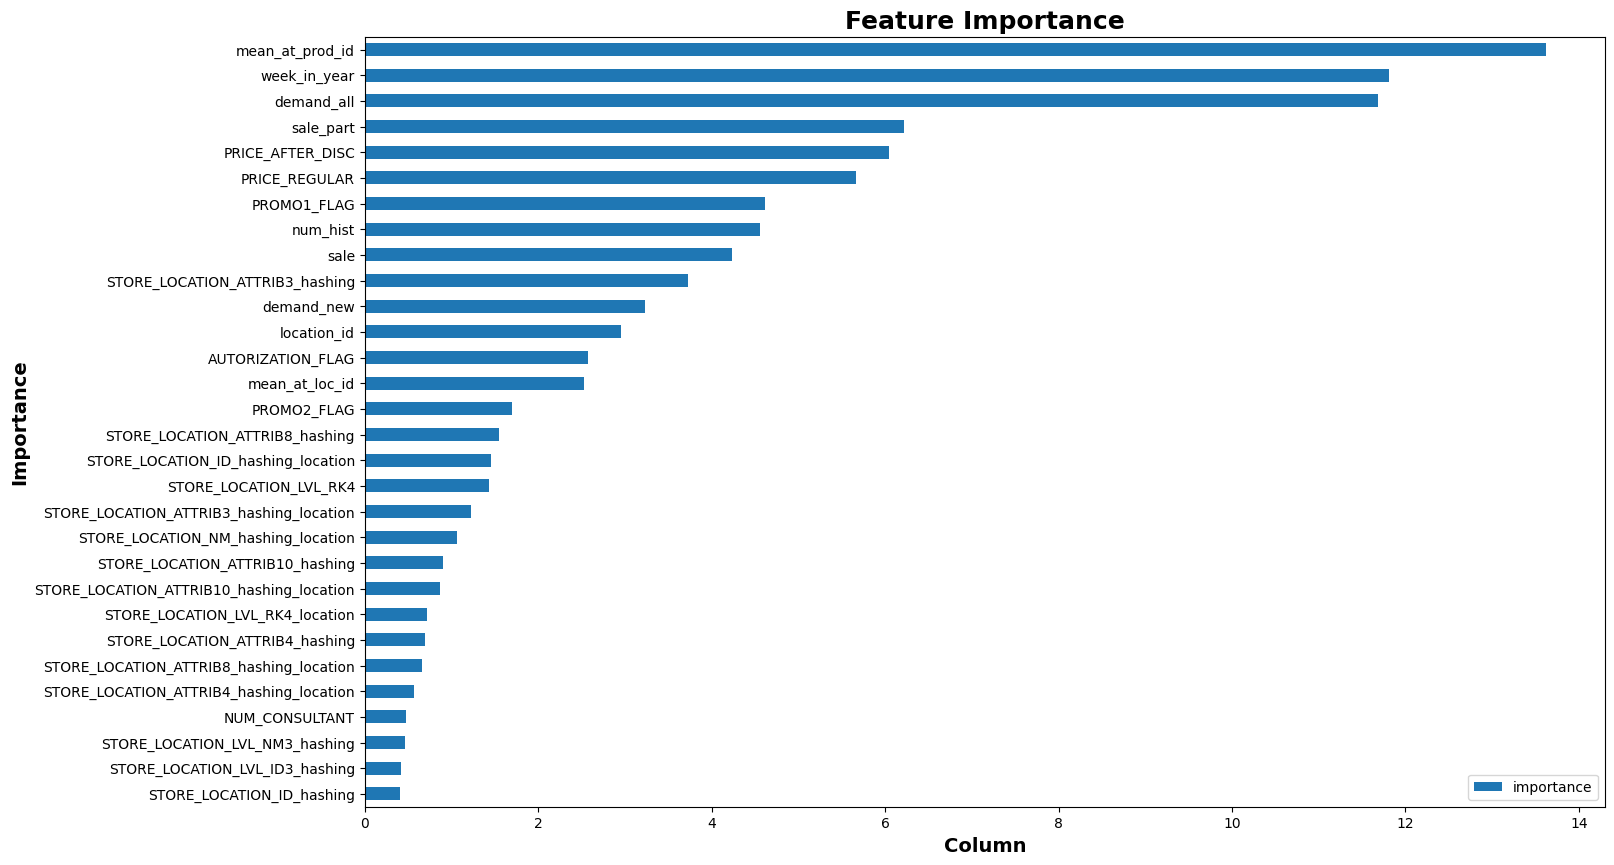

In [37]:
fi = pd.DataFrame({'column': classifier.feature_names_, 'importance': classifier.feature_importances_})
fi.sort_values('importance', ascending=True).tail(30).set_index('column').plot.barh(figsize=(16, 10))
plt.ylabel('Importance', weight='bold', size=14)
plt.xlabel('Column', weight='bold', size=14)
plt.title('Feature Importance', weight='bold', size=18)
plt.show()
